### Esercitazione 17 - KST (Know Sure Thing)
#### Argomenti

* indicatore KST
* implementazione di una strategia che sfrutti l'indicatore KST

Il KST è un oscillatore Momentum nato per rendere più facilmente interpretabili i grafici prodotti dall'indicatore RoC.
Il KST è calcolato prendendo la media mobile di quattro diversi periodi del RoC e sommandole a meno di un fattore
moltiplicativo; un'ulteriore media mobile, in genere a 9 periodi, costruita sull'indicatore ottenuto crea una
linea di segnale (una linea di segnale in un indicatore/oscillatore è usata per generare segnali di buy/sell o per
indicare cambiamenti nel trend osservato).
KST è calcolato secondo la seguente formula:

KST = RCMA_1 + (RCMA_2 * 2) + (RCMA_3 * 3) + (RCMA_4 * 4)

dove:    
RCMA_1 = 10 - media mobile 10 periodi RoC    
RCMA_2 = 10 - media mobile 15 periodi RoC    
RCMA_3 = 10 - media mobile 20 periodi RoC    
RCMA_4 = 15 - media mobile 30 periodi RoC    

L'oscillatore KST può essere utilizzato allo stesso modo di altri oscillatori Momentum: i segnali di trading
vengono generati quando il KST attraversa la linea del segnale, ma si possono anche cercare eventuali convergenze e
divergenze con il prezzo, condizioni di ipercomprato o ipervenduto o incroci della linea centrale.
Spesso è combinato con altre metodologie di analisi tecnica, ad esempio, altri indicatori non di momentum,
pattern grafici o pattern di candele, ...

In [1]:
import pandas_datareader as pdr
import mplfinance as mpf
from datetime import datetime, timedelta
import talib
import numpy as np

In [2]:
start = datetime.now() - timedelta(days=365)
candles = pdr.get_data_yahoo("TSLA", start)

candles.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-12-01,198.919998,191.800003,197.080002,194.699997,80046200.0,194.699997
2022-12-02,196.250000,191.110001,191.779999,194.860001,73533400.0,194.860001
2022-12-05,191.270004,180.550003,189.440002,182.449997,93122700.0,182.449997
2022-12-06,183.649994,175.330002,181.220001,179.820007,92024300.0,179.820007
2022-12-07,179.380005,173.330002,175.029999,173.759995,21816813.0,173.759995


In [3]:
candles['roc'] = talib.ROC(candles['Close'])

candles['rcma_1'] = 10 - talib.SMA(candles['roc'], timeperiod=10)
candles['rcma_2'] = 10 - talib.SMA(candles['roc'], timeperiod=15)
candles['rcma_3'] = 10 - talib.SMA(candles['roc'], timeperiod=20)
candles['rcma_4'] = 15 - talib.SMA(candles['roc'], timeperiod=30)

candles['kst'] = candles['rcma_1'] + candles['rcma_2'] * 2 + candles['rcma_3'] * 3 + candles['rcma_4'] * 4
candles['kst_sign'] = talib.SMA(candles['kst'], timeperiod=9)

candles = candles[39:] # rimozione candele con valori NaN derivanti dal calcolo delle medie mobili
candles.tail()

,High,Low,Open,Close,Volume,Adj Close,roc,rcma_1,rcma_2,rcma_3,rcma_4,kst,kst_sign
Date,,,,,,,,,,,,,
2022-12-01,198.919998,191.800003,197.080002,194.699997,80046200.0,194.699997,4.162208,16.269402,19.066738,18.851063,20.864618,194.414538,206.740092
2022-12-02,196.250000,191.110001,191.779999,194.860001,73533400.0,194.860001,6.382051,14.138466,17.623305,18.725660,20.220046,186.442238,204.295340
2022-12-05,191.270004,180.550003,189.440002,182.449997,93122700.0,182.449997,1.254229,12.698154,16.590101,18.500432,20.049280,181.576772,200.850617
2022-12-06,183.649994,175.330002,181.220001,179.820007,92024300.0,179.820007,7.118611,10.504154,15.043481,17.809117,19.636924,172.566162,196.169255
2022-12-07,179.380005,173.330002,175.029999,173.759995,21816813.0,173.759995,2.265900,9.159425,13.915041,16.996245,19.652541,166.588405,191.591349


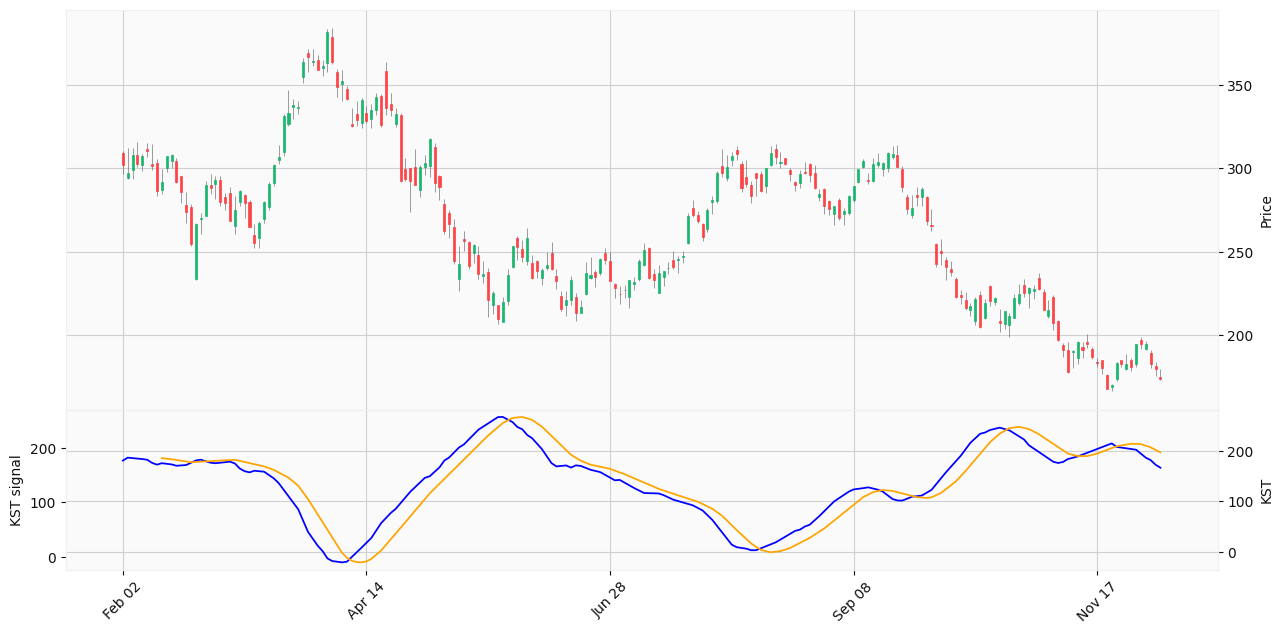

In [4]:
kst_plot = mpf.make_addplot(candles['kst'], color='blue', panel=1, ylabel='KST')
kst_sign_plot = mpf.make_addplot(candles['kst_sign'], color='orange', panel=1, ylabel='KST signal')
mpf.plot(candles, addplot=[kst_plot, kst_sign_plot], type='candle', style='yahoo', figsize=(16, 8), warn_too_much_data=len(candles))

In [5]:
# implementazione di una strategia che sfrutta gli incroci tra la linea dell'indicatore KST e quella del KST-Signal

print('backtesting:', candles.iloc[0].name, '...', candles.iloc[-1].name, '\n')
i = 2
wallet = 0
position = 0
actions = []
while i < len(candles):
    c = candles.iloc[i]
    c_1 = candles.iloc[i - 1]

    # entrata in buy e check se uscire da sell
    if c.kst > c.kst_sign and c_1.kst < c_1.kst_sign:
        if position == 0:
            position = 1
            actions.append([c.name, c.Close, np.nan, np.nan, 1])
        elif position == -1:
            position = 1
            actions[-1][2] = c.name
            actions[-1][3] = c.Close
            actions.append([c.name, c.Close, np.nan, np.nan, 1])

    # entrata in sell e check se uscire da buy
    if c.kst < c.kst_sign and c_1.kst > c_1.kst_sign:
        if position == 0:
            position = -1
            actions.append([c.name, c.Close, np.nan, np.nan, -1])
        elif position == 1:
            position = -1
            actions[-1][2] = c.name
            actions[-1][3] = c.Close
            actions.append([c.name, c.Close, np.nan, np.nan, -1])

    # check uscita da buy
    if position == 1 and not(c.kst > c.kst_sign and c_1.kst < c_1.kst_sign):
        position = 0
        actions[-1][2] = c.name
        actions[-1][3] = c.Close

    # check uscita da sell
    if position == -1 and not(c.kst < c.kst_sign and c_1.kst > c_1.kst_sign):
        position = 0
        actions[-1][2] = c.name
        actions[-1][3] = c.Close

    i += 1

if np.isnan(actions[-1][3]):
    actions[-1][2] = candles.iloc[-1].name
    actions[-1][3] = candles.iloc[-1].Close

vincite = 0
for act in actions:
    res = (act[3] - act[1]) * act[-1]
    wallet += res
    if res > 0:
        vincite += 1
    print(act[0], '\t', act[2] - act[0], '\t', res)

print('\nPerformance finale:', wallet, '- vinte', vincite, 'su', len(actions))

backtesting: 2022-02-02 00:00:00 ... 2022-12-07 00:00:00 

2022-02-23 00:00:00 	 1 days 00:00:00 	 12.24334716796875
2022-03-02 00:00:00 	 1 days 00:00:00 	 13.5333251953125
2022-03-03 00:00:00 	 1 days 00:00:00 	 -0.333343505859375
2022-03-08 00:00:00 	 1 days 00:00:00 	 -11.523345947265625
2022-04-12 00:00:00 	 1 days 00:00:00 	 11.806671142578125
2022-05-31 00:00:00 	 1 days 00:00:00 	 5.9633331298828125
2022-08-12 00:00:00 	 3 days 00:00:00 	 9.290008544921875
2022-09-16 00:00:00 	 3 days 00:00:00 	 -5.720001220703125
2022-09-27 00:00:00 	 1 days 00:00:00 	 4.8699951171875
2022-10-25 00:00:00 	 1 days 00:00:00 	 -2.220001220703125
2022-11-11 00:00:00 	 3 days 00:00:00 	 -5.0200042724609375
2022-11-29 00:00:00 	 1 days 00:00:00 	 -13.8699951171875

Performance finale: 19.019989013671875 - vinte 6 su 12


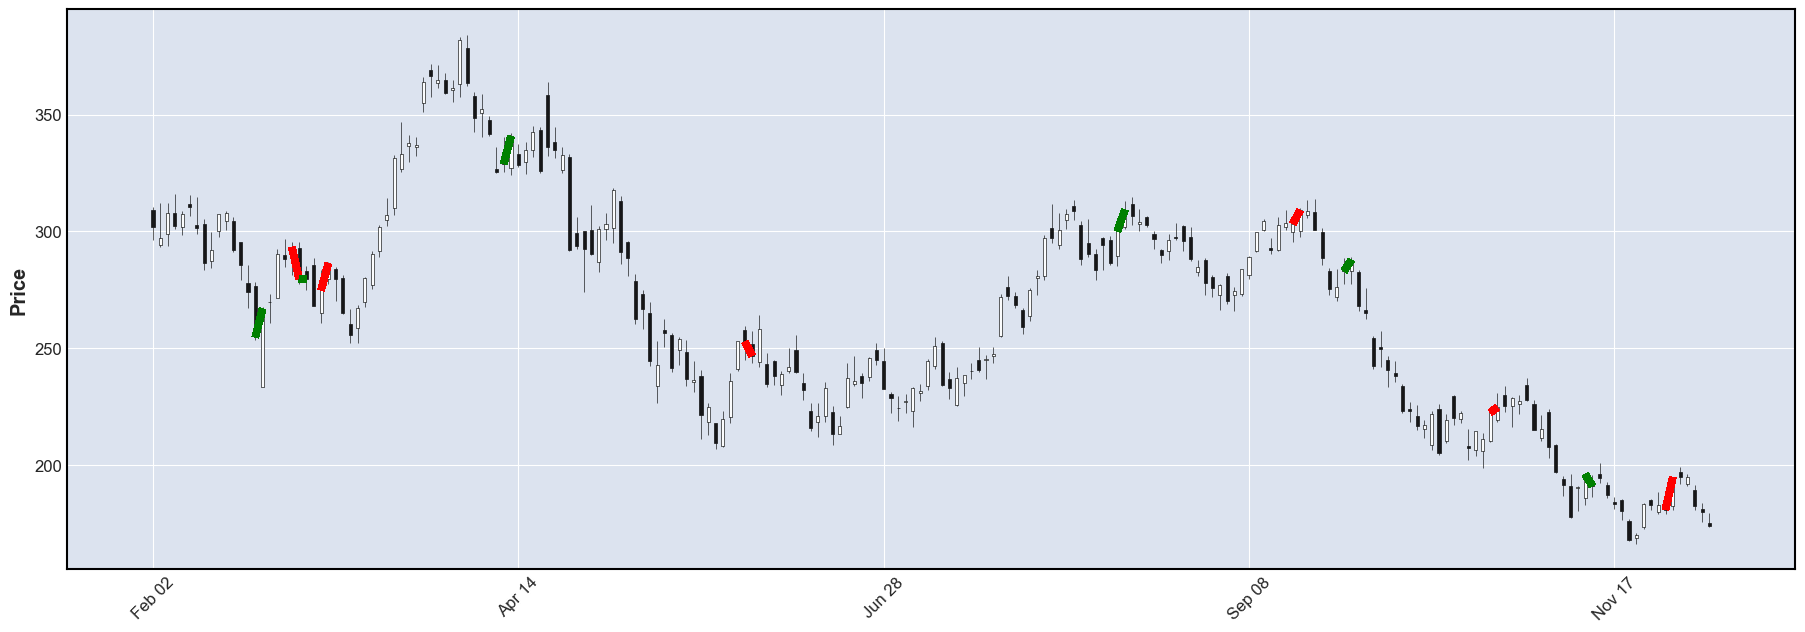

In [6]:
# visualizzazione operazioni simulate:

colors = ['green' if act[4] == 1 else 'red' for act in actions]
lines = [[(act[0], act[1]), (act[2], act[3])] for act in actions]

mpf.plot(candles, alines=dict(alines=lines, colors=colors, linewidths=5), type='candle', figsize=(24, 8), warn_too_much_data=len(candles))